# Libraries

In [39]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
#Librairies usuelles
import os
import numpy as np
import pandas as pd
from datetime import datetime

#Plots
import plotly.express as px
import matplotlib.pyplot as plt

# Nuage de mot 
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk

# Tokenisation, lemmatiser, stop words
import re
from nltk.tokenize  import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
import spacy
nlp = spacy.load('en_core_web_sm')

# Distance entre les données de test et les données 
import gensim
from gensim.models import Word2Vec
import sklearn
from  sklearn.manifold import TSNE
from tqdm import tqdm
tqdm.pandas()

# Data Access
Nous accèdons aux données qui se composent de Fake (fausses) et True (vraies). Nous allons les séparées en fake et true dataset.

In [40]:
fake_df=pd.read_csv("data/Fake.csv")
fake_df.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

In [41]:
true_df=pd.read_csv("data/True.csv")
true_df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

In [42]:
validation_df=pd.read_csv("data/validation_data.csv")
validation_df.head()

Unnamed: 0                                               text  isFake
0           0  Daniel Greenfield, a Shillman Journalism Fello...   False
1           1  Google Pinterest Digg Linkedin Reddit Stumbleu...   False
2           2  U.S. Secretary of State John F. Kerry said Mon...    True
3           3  — Kaydee King (@KaydeeKing) November 9, 2016 T...   False
4           4  It's primary day in New York and front-runners...    True

# Data cleaning
Dans ce dataframe nous analysons si les données sont propres (si elles contiennet des Nan Values, si le type des variables est approprié est approprié. Dans un premier temps nous allons créer un dataframe globale qui contient l'intégralité des données et on va créer une colonne "IsFake" qui contient "True" ou "False" pour classifier les données.


**Des Informations generales**



In [43]:
fake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [44]:
true_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [45]:
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   text        6335 non-null   object
 2   isFake      6335 non-null   bool  
dtypes: bool(1), int64(1), object(1)
memory usage: 105.3+ KB


In [46]:
fake_df.shape 

(23481, 4)

In [47]:
true_df.shape

(21417, 4)

**Les datasets true et fake ont à peu près la même taille**

**Ni fake ni true ni valid n'a de données nulles**

## Etude de l'équilibrage des données
Nous alons observer si il existe un équilibre dans les données.

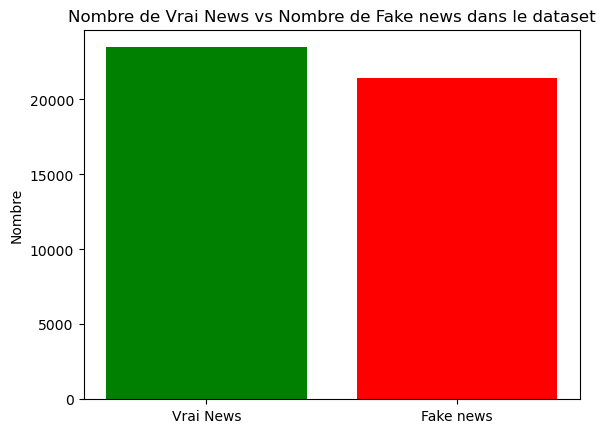

On peut observer un nombre assez équilibrer de notre modèle de 47.7% des données sont fake et 52.3% sont vrai. Ce qui peut nous motiver à enlever des données Fake, afin d'avoir un parfait équilibre entre les deux catégories. Nous allons donc enlever des données du dataset Fake.


In [48]:
#Comparer les tailles de Fake et True permet de savoir si les données sont bien équilibrées (bien distribuées)
fake_value_count=fake_df.shape[0]
true_value_count=true_df.shape[0]
total_news_number= fake_value_count+true_value_count

#donner les valeurs en pourcentage
percentage_true_news=true_value_count/total_news_number
percentage_fake_news=fake_value_count/total_news_number

isFake_counts = {'False': fake_value_count, 'True': true_value_count}  

# Affichage du diagramme pour plus de visibilité 
fig, ax = plt.subplots()
ax.bar(isFake_counts.keys(), isFake_counts.values(), color=['green', 'red'])

ax.set_ylabel('Nombre')
ax.set_title('Nombre de Vrai News vs Nombre de Fake news dans le dataset')
ax.set_xticks(list(isFake_counts.keys()))
ax.set_xticklabels(['Vrai News', 'Fake news'])

plt.show()
print(f"On peut observer un nombre assez équilibrer de notre modèle de {round(percentage_true_news*100,2)}% des données sont fake et {round(percentage_fake_news*100,2)}% sont vrai. Ce qui peut nous motiver à enlever des données Fake, afin d'avoir un parfait équilibre entre les deux catégories. Nous allons donc enlever des données du dataset Fake.")

**Lire Validation_Data**

In [49]:
validation_df = pd.read_csv('data/validation_data.csv')
validation_df.info

<bound method DataFrame.info of       Unnamed: 0                                               text  isFake
0              0  Daniel Greenfield, a Shillman Journalism Fello...   False
1              1  Google Pinterest Digg Linkedin Reddit Stumbleu...   False
2              2  U.S. Secretary of State John F. Kerry said Mon...    True
3              3  — Kaydee King (@KaydeeKing) November 9, 2016 T...   False
4              4  It's primary day in New York and front-runners...    True
...          ...                                                ...     ...
6330        6330  The State Department told the Republican Natio...    True
6331        6331  The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...   False
6332        6332   Anti-Trump Protesters Are Tools of the Oligar...   False
6333        6333  ADDIS ABABA, Ethiopia —President Obama convene...    True
6334        6334  Jeb Bush Is Suddenly Attacking Trump. Here's W...    True

[6335 rows x 3 columns]>

In [50]:
validation_df.columns

Index(['Unnamed: 0', 'text', 'isFake'], dtype='object')

## Tokenisation, normalisation, application des stop words, stemming ...
Voir s'il n'ya pas de données vides


In [51]:
# Pour title

#Supprimer les cases vides
fake_df = fake_df.dropna(subset=['title'])

#Supprimer les doublons
fake_df = fake_df.drop_duplicates(subset=['title'])

#Supprimer les cases vides
true_df = true_df.dropna(subset=['title'])

#Supprimer les doublons
true_df = true_df.drop_duplicates(subset=['title'])

#Supprimer les cases vides 
#validation_df = validation_df.dropna(subset=['title'])

#Supprimer les doublons
#validation_df = validation_df.drop_duplicates(subset=['title'])

In [52]:
# Pour text 

#Supprimer les cases vides
fake_df = fake_df.dropna(subset=['text'])

#Supprimer les doublons
fake_df = fake_df.drop_duplicates(subset=['text'])

#Supprimer les cases vides
true_df = true_df.dropna(subset=['text'])

#Supprimer les doublons
true_df = true_df.drop_duplicates(subset=['text'])

#Supprimer les cases vides 
validation_df = validation_df.dropna(subset=['text'])

#Supprimer les doublons
validation_df = validation_df.drop_duplicates(subset=['text'])

#### Normalisation des données
Import des outils de tokenisation, lematisation et stopwords

Nous definisons la fonction

In [53]:
#fonction pour nettoyer, tokenizer, lemmatiser  et stemmer

stemmer = PorterStemmer()
# Charger la liste des stopwords en anglais
stopwords_en = set(stopwords.words('english'))

def process_text(text):
    #convertir en minuscules
    text = text.lower()
    #Supprimer les caractères non alphabétiques
    text=re.sub(r'[^a-zA-Z\s]','',text)
    #Enlever html
    text=re.sub(r'\d+','',text)
    #supprimer la ponctuation
    text=re.sub(r'[^\w\s]', '', text)
    #Tokenisation avec NLTK
    tokens= word_tokenize(text)
    #supprimer les stopwords
    tokens=[word for word in tokens if word not in stopwords_en]
    #lemmatisation avec spacy
    doc = nlp(" ".join(tokens))
    lemmatized_tokens=[token.lemma_ for token in doc]
    #stemming 
    stemmer_tokens = [stemmer.stem(token) for token in lemmatized_tokens]
    #Rejoindre les tokens en une chaine
    processed_text = ' '.join(stemmer_tokens)
    return  processed_text

**Cerner les deux colonnes à normaliser et appliquer la fonction sur toutes les lignes du dataset**

In [33]:
# title
columns_to_clean = ['title','text']

#fake
#Appliquer la fonction à cette colonne 
for column in columns_to_clean:
    fake_df[column + '_processed']= fake_df[column].progress_apply(process_text)

#Exporter les données clean en csv sans les indices
fake_df.to_csv("data/fake_clean.csv",index=False)

100%|██████████| 17450/17450 [08:36<00:00, 33.78it/s]


In [35]:
#true
#Appliquer la fonction à cette colonne
for column in columns_to_clean:
    true_df[column + '_processed'] = true_df[column].progress_apply(process_text)

#Exporter les données clean en csv sans les indices
true_df.to_csv("data/true_clean.csv", index=False)


100%|██████████| 20821/20821 [09:40<00:00, 35.88it/s]


In [36]:
#valid
#Appliquer la fonction à cette colonne
validation_df['text_processed']= validation_df['text'].progress_apply(process_text)

#Exporter les données clean en csv sans les indices
validation_df.to_csv("data/valid_clean.csv",index=False)

100%|██████████| 6060/6060 [05:20<00:00, 18.90it/s]


In [122]:
# we load the "/data/fake_clean.csv" data into fake_df, "/data/true_clean.csv" into true_df and "/data/valid_clean.csv" into validation_df

fake_df = pd.read_csv("data/fake_clean.csv")
true_df = pd.read_csv("data/true_clean.csv")
validation_df = pd.read_csv("data/valid_clean.csv")

**Etudier l'équilibrage au sens des thèmes abordés**

Pour assurer un bon équilibrage il ne faut pas seulement se fier aux nombres mais aussi voir si le dataset Fake traite à peu près des mêmes sujets que le dataset True car dans le cas contraire, l'IA pourrait se baser sur le sens pour décider de la justesse de l'information.

Exemple: Si le dataset fake parle plus de trump et le dataset True parle plus de la crise sanitaire celà pourrait biaiser la justesse de l'IA. 
Dès qu'elle aura une information sur Donald Trum elle aura tendance à Pré-classer l'information en tant que Fake News/même Deep Fake, de la même manière elle aura tendance à classer les informations sur la crise sanitaire comme vraies car c'est le sujet qui se rapproche le plus des données True.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MIKED\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


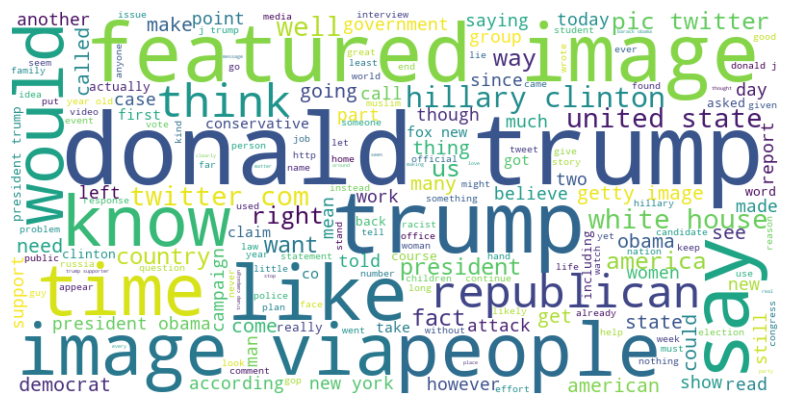

In [123]:
nltk.download('stopwords')


# Ajouter des mots personnalisés à la liste des stopwords
custom_stopwords = ["said", "ones", "will","one","even","also","u"]
stopwords_en.update(custom_stopwords)

# Concaténer toutes les valeurs de la colonne "text" en excluant les stopwords
text_fake = ' '.join([word.lower() for sentence in fake_df["text"].astype(str) for word in sentence.split() if word.lower() not in stopwords_en])

# Générer le nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords_en).generate(text_fake)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


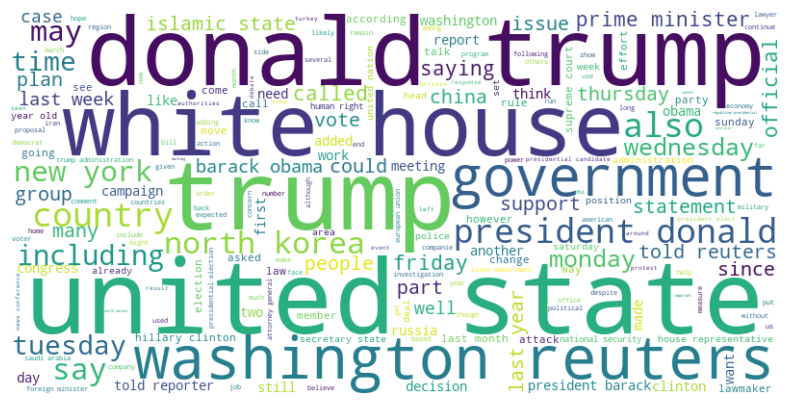

In [124]:
# De même pour les données réelles (True)

# Charger la liste des stopwords en anglais
stopwords_en = set(stopwords.words('english'))

# Ajouter des mots personnalisés à la liste des stopwords
custom_stopwords = ["said", "ones", "will","one","even","u"]
stopwords_en.update(custom_stopwords)

# Concaténer toutes les valeurs de la colonne "text" en excluant les stopwords
text_true = ' '.join([word.lower() for sentence in true_df["text"].astype(str) for word in sentence.split() if word.lower() not in stopwords_en])

# Générer le nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords_en).generate(text_true)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

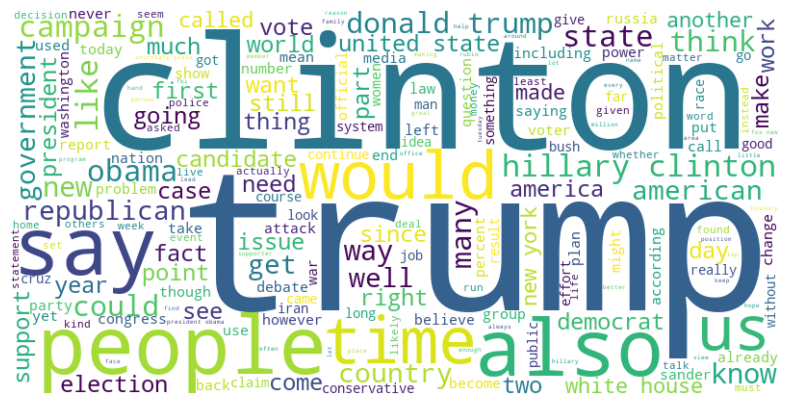

In [125]:
# De même pour les données Validation (Valid)

# Charger la liste des stopwords en anglais
stopwords_en = set(stopwords.words('english'))

# Ajouter des mots personnalisés à la liste des stopwords
custom_stopwords = ["said", "ones", "will","one","even","u","may"]
stopwords_en.update(custom_stopwords)

# Concaténer toutes les valeurs de la colonne "text" en excluant les stopwords
text_valid = ' '.join([word.lower() for sentence in validation_df["text"].astype(str) for word in sentence.split() if word.lower() not in stopwords_en])

# Générer le nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords_en).generate(text_valid)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**On remarque que dans les 3 datasets Donald Trump est la star! c'est bon signe pour la distribution des données qui ont l'air d'être homogènes pour les mots secondaires** 

In [126]:
fake_df = fake_df.sample(n=len(true_df), replace=True, random_state=42)


In [127]:
# On ajoute à chaque dataframe la colonne "isFake"
fake_df["isFake"]=True
fake_df.head(1)

title  \
15795  GERMANY: Father And Sons Stab 20 Yr Old Syrian...   

                                                    text          subject  \
15795  This story is for everyone who believes hundre...  Government News   

               date                                    title_processed  \
15795  Oct 18, 2015  germani father son stab yr old syrian daughter...   

                                          text_processed  isFake  
15795  stori everyon believ hundr thousand muslim syr...    True

In [128]:
true_df["isFake"]=False
true_df.head(1)

title  \
0  As U.S. budget fight looms, Republicans flip t...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   

                 date                                    title_processed  \
0  December 31, 2017   us budget fight loom republican flip fiscal sc...   

                                      text_processed  isFake  
0  washington reuter head conserv republican fact...   False

**Concatener le fake et le True dans un seul dataframe df**

In [129]:
df=pd.concat([fake_df,true_df])
df=df.reset_index().drop(['index'],axis=1) #on reset l'index de notre dataset.

In [130]:
df.isFake.unique()

array([ True, False])

In [131]:
#nous allons maintenant adapter les types de données
# Dans quelle format sont les données ?

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41642 entries, 0 to 41641
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            41642 non-null  object
 1   text             41642 non-null  object
 2   subject          41642 non-null  object
 3   date             41642 non-null  object
 4   title_processed  41642 non-null  object
 5   text_processed   41638 non-null  object
 6   isFake           41642 non-null  bool  
dtypes: bool(1), object(6)
memory usage: 1.9+ MB


In [132]:
#Nous allons convertir la colonne "date" en format datetime
df['date'] = df['date'].str.replace('January', 'Jan')
df['date'] = df['date'].str.replace('February', 'Feb')
df['date'] = df['date'].str.replace('March', 'Mar')
df['date'] = df['date'].str.replace('April', 'Apr')
df['date'] = df['date'].str.replace('May', 'May')
df['date'] = df['date'].str.replace('June', 'Jun')
df['date'] = df['date'].str.replace('July', 'Jul')
df['date'] = df['date'].str.replace('August', 'Aug')
df['date'] = df['date'].str.replace('September', 'Sep')
df['date'] = df['date'].str.replace('October', 'Oct')
df['date'] = df['date'].str.replace('November', 'Nov')
df['date'] = df['date'].str.replace('December', 'Dec')

In [133]:
# changer "date" en datetime
unique_dates = df['date'].unique()

invalid_format_dates = []
for date in unique_dates:
    try:
        pd.to_datetime(date.strip(), format='mixed') # on utilise le format 'mixed' pour gérer les dates avec des mois abrégés (ex: 'Jan', 'Feb', 'Mar', etc.)
    except ValueError as e:
        print(f"Error for date '{date}': {e}")
        invalid_format_dates.append(date)

print("Dates invalides:", invalid_format_dates)

Error for date 'MSNBC HOST Rudely Assumes Steel Worker Would Never Let His Son Follow in His Footsteps…He Couldn’t Be More Wrong [Video]': Unknown datetime string format, unable to parse: MSNBC HOST Rudely Assumes Steel Worker Would Never Let His Son Follow in His Footsteps…He Couldn’t Be More Wrong [Video], at position 0
Error for date 'https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg': Unknown datetime string format, unable to parse: https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg, at position 0
Error for date 'https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/': Unknown datetime string format, unable to parse: https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/, at position 0
Dates invalides: ['MSNBC HOST Rudely Assumes Steel Worker Would Never 

Nous pouvons voir que les données ne sont toutes du meme format, il va falloire changer cela. Nous pouvons identifier 3 formats qui ne respectent pas la forme suivante "Mois :
- 'd-MMM-yy' (comme '19-Feb-18')
- 'MMM d, yyyy' (comme 'Dec 31, 2017').
- "des URL de site" 

Concernant les URL nous allons éliminer ces lignes du dataset. Pour les autres valeurs nous allons concevoir un algorithme pour les transformer dans un dataframe convenable.

In [134]:
# filtrer et supprimer les URL, pour simplifier nous allons dire que si 
#la ligne contient le suit pas les formats 'd-MMM-yy' ou 'MMM d, yyyy'  
#alors on supprime la ligne.
df = df[~df['date'].isin(invalid_format_dates)]
df['date'] = pd.to_datetime(df['date'], format='mixed')

In [135]:
#print the dates of the dataframe who have isFake as False
df[df['isFake']==False]['date'] #ce sont les vrai news

20821   2017-12-31
20822   2017-12-29
20823   2017-12-31
20824   2017-12-30
20825   2017-12-29
           ...    
41637   2017-08-21
41638   2017-08-22
41639   2017-08-22
41640   2017-08-22
41641   2017-08-22
Name: date, Length: 20821, dtype: datetime64[ns]

nous avons donc modifié les formats des dates de D-M-Y.
dates_numpy_array

In [136]:
print("Unique valeus in isFake:", df['isFake'].unique())

Unique valeus in isFake: [ True False]


In [137]:
#nous verifions si il y a des valeurs manquantes dans les dates
print("Nan values in date column:", df['date'].isna().sum())

Nan values in date column: 0


Nous avons prouvé que il existe des pas values, donc nous allons eliminer les lignes.

Nous avons donc néttoyé la colonne date. Nous verifions les autres colonnes.

In [138]:
df.columns

Index(['title', 'text', 'subject', 'date', 'title_processed', 'text_processed',
       'isFake'],
      dtype='object')

In [139]:
#print nan values in title
print(f"Nan values in title: {df['title'].isnull().sum()}")

Nan values in title: 0


In [140]:
#print nan values in text
print(f"Nan values in text: {df['text'].isnull().sum()}")

Nan values in text: 0


In [141]:
print(f"Nan values in subject: {df['subject'].isnull().sum()}")

Nan values in subject: 0


In [142]:
print(f"Nan values in subject: {df['subject'].isnull().sum()}")

Nan values in subject: 0


In [143]:
#we drop the rows that have text_processed nan values

df = df.dropna(subset=['text_processed'])

Notre dataset est près à l'emplois.

# Data analysis + Visualisation
Nous avons plusieurs points à analyser avant de créer notre model, voici les questions sur lesquelles nous nous focalisons pour répondre aux questions:
Types de "subject" dans le DataFrame :

**Analyse de les sujets les plus présents**
- Combien de catégories uniques de "subject" existent-elles ?
- Y a-t-il une distribution inégale des sujets entre les news fake et vraies ?

**Sujet avec le plus de fake news ou de vraies news**
- Y a-t-il des sujets spécifiques plus susceptibles d'être associés à des fake news ?

**Analyse de la longueur des textes :**
- Quelle est la distribution de la longueur des textes pour les fake news par rapport aux vraies news ?
- La longueur du texte est-elle un indicateur potentiel de fiabilité ?
Répétition des titres :

**Analyse des dates :**
- Quelles sont les dates minimales et maximales ? Y a-t-il des tendances temporelles dans les fake news ?
- Y a-t-il des périodes spécifiques où les fake news sont plus fréquentes ?

L'analyse va nous permettre des réponse à ces questions.

**Combien de catégories uniques de "subject" existent-elles ?**

In [144]:
print(f"Nous avons {len(df.subject.unique())} sujets différents")

Nous avons 7 sujets différents


**Y a-t-il une distribution inégale des sujets entre les news fake et vraies ?**

On observe déja le nombre de données Fake et true dans son ensemble:

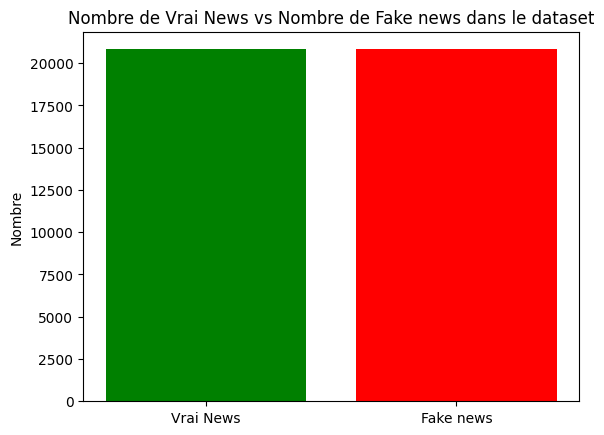

On peut observer un nombre assez équilibrer de notre modèle de 50.01% des données sont fake et 49.99% sont vrai. Ce est un quasi parfait équilibre.


In [145]:
fake_value_count=df[df["isFake"]==True].shape[0]
true_value_count=df[df["isFake"]==False].shape[0]
total_news_number= fake_value_count+true_value_count

percentage_true_news=true_value_count/total_news_number
percentage_fake_news=fake_value_count/total_news_number

# Sample data
isFake_counts = {'False': fake_value_count, 'True': true_value_count}  # Assuming these are the counts

# Bar chart
fig, ax = plt.subplots()
ax.bar(isFake_counts.keys(), isFake_counts.values(), color=['green', 'red'])

ax.set_ylabel('Nombre')
ax.set_title('Nombre de Vrai News vs Nombre de Fake news dans le dataset')
ax.set_xticks(list(isFake_counts.keys()))
ax.set_xticklabels(['Vrai News', 'Fake news'])

plt.show()
print(f"On peut observer un nombre assez équilibrer de notre modèle de {round(percentage_true_news*100,2)}% des données sont fake et {round(percentage_fake_news*100,2)}% sont vrai. Ce est un quasi parfait équilibre.")

In [146]:
df.groupby('subject')['isFake'].value_counts()

subject          isFake
Government News  True        645
News             True      10649
US_News          True        970
left-news        True        853
politics         True       7696
politicsNews     False     11146
worldnews        False      9674
Name: count, dtype: int64

In [147]:
# Grouper par 'subject' et compter les occurrences de True et False dans 'isFake'
count_by_subject = df.groupby('subject')['isFake'].value_counts().unstack().fillna(0)

# Afficher le résultat
print(count_by_subject)

isFake             False    True 
subject                          
Government News      0.0    645.0
News                 0.0  10649.0
US_News              0.0    970.0
left-news            0.0    853.0
politics             0.0   7696.0
politicsNews     11146.0      0.0
worldnews         9674.0      0.0


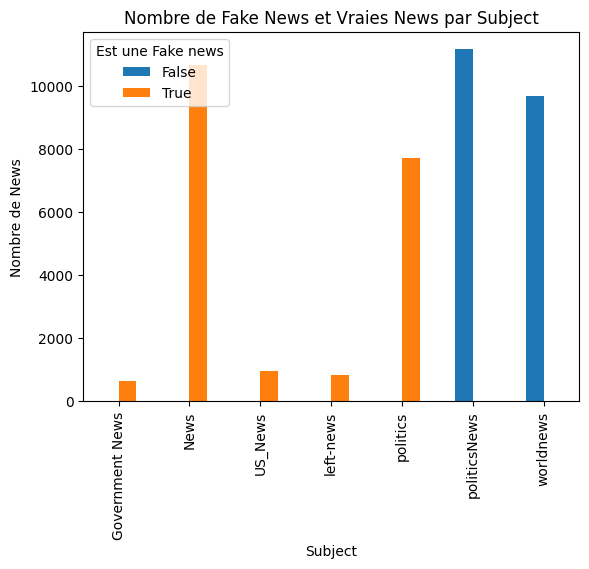

In [148]:
# Créer un graphique à barres empilées
count_by_subject.plot(kind='bar')

# Ajouter des titres et labels
plt.title('Nombre de Fake News et Vraies News par Subject')
plt.xlabel('Subject')
plt.ylabel('Nombre de News')

# Afficher la légende
plt.legend(title="Est une Fake news",loc="upper left")

# Afficher le graphique
plt.show()


La distribution des fake news et des true news est assez innégal si on les reproupe par subject, il es très probable qu'elle ne soit pas un bon estimateur pour détecter les fake news. 
Il serait envisageable:
- Soit utiliser des techniques comme SMOTE pour générer des nouvelles données de la classe minoritaire.
- soit enlever la colonne "subject" du dataset. (car à la fin, ce sont des news, peut importe d'où elles viennent.)

**Sujet avec le plus de fake news ou de vraies news**:
- PoliticsNews
- Worldnews

**Analyse de la longueur des Titres :**

In [149]:
#Quelle est la distribution de la longueur des titres pour les fake news par rapport aux vraies news ?
titles=df[['title_processed','isFake']]
titles.head()

title_processed  isFake
0  germani father son stab yr old syrian daughter...    True
1  trump steal idea north korean propaganda parod...    True
2  trump famili express te cruz rnc speech priceless    True
3  reinc priebu embarrass snarki nbc meet press h...    True
4  break gang can not shoot straight vote cancel ...    True

In [150]:
title_length=[]
for title in titles['title_processed']:
    title_length.append(len(title))
titles['title length']=title_length

In [151]:
#on détermine la moyenne de Fake et True
title_length=titles.drop(['title_processed'],axis=1)
title_length

isFake  title length
0        True            98
1        True            79
2        True            49
3        True            90
4        True            60
...       ...           ...
41637   False            63
41638   False            44
41639   False            29
41640   False            47
41641   False            39

[41633 rows x 2 columns]

In [152]:
true_title_length=title_length[title_length['isFake']==False]
true_title_length.describe()

title length
count  20820.000000
mean      49.624448
std        8.010538
min       16.000000
25%       44.000000
50%       50.000000
75%       55.000000
max       89.000000

In [153]:
false_title_length=title_length[title_length['isFake']==True]
false_title_length.describe()

title length
count  20813.000000
mean      64.159948
std       18.751068
min        8.000000
25%       52.000000
50%       62.000000
75%       72.000000
max      222.000000

In [154]:
# Creating plot
fig=px.box(title_length,x='isFake',y='title length',points='all')
 
# show plot
fig.show()

- Les titres des fake news ont une longueur moyenne significativement plus longue ( 222 mots) par rapport aux vrai news (89 mots).
- La variabilité (écart-type) dans les longueurs de titres des fake news (18.75 mots) est plus grande que celle des vrai news (8.01 mots), indiquant une plus grande diversité dans la longueur des titres des fake news.
- Les vrai news présentent une longueur de titre plus uniforme
- Les valeurs minimales et maximales montrent que les fake news ont une plage plus large de longueur de titre.
- La distribution des quartiles montre que les titres de vrai news sont concentrés dans une plage plus étroite.

On peut conclure que c'est un indicateur potentiel pour la détection de fake news. Il serait interessant de ne pas les inclure dans le le modèle.

**Analyse de la longueur des textes :**

In [155]:
textes=df[['text_processed','isFake']]
textes.head()

text_processed  isFake
0  stori everyon believ hundr thousand muslim syr...    True
1  jesu fcke christ presid moron satisfi simpli w...    True
2  make mistak ted cruz horribl get admir abil st...    True
3  entir premis chuck todd posit two medium repor...    True
4  speaker ryan cusp achiev ambit we ve year come...    True

In [156]:
# we check the nan values in textes
textes.isnull().sum()

text_processed    0
isFake            0
dtype: int64

In [157]:
text_length=[]
for text in textes['text_processed']:
    text_length.append(len(text))
textes['text length']=text_length
textes

text_processed  isFake  text length
0      stori everyon believ hundr thousand muslim syr...    True         2524
1      jesu fcke christ presid moron satisfi simpli w...    True         2935
2      make mistak ted cruz horribl get admir abil st...    True         1907
3      entir premis chuck todd posit two medium repor...    True          793
4      speaker ryan cusp achiev ambit we ve year come...    True          454
...                                                  ...     ...          ...
41637  unit nation reuter two north korean shipment s...   False         1855
41638  london reuter lexisnexi provid legal regulator...   False          508
41639  minsk reuter shadow disus sovietera factori mi...   False         1157
41640  moscow reuter vatican secretari state cardin p...   False          767
41641  jakarta reuter indonesia buy sukhoi fighter je...   False          913

[41633 rows x 3 columns]

In [158]:
true_text_length=textes[textes['isFake']==False]
true_text_length.describe()

text length
count  20820.000000
mean    1474.373871
std     1025.190753
min       91.000000
25%      575.000000
50%     1375.000000
75%     1987.250000
max    15761.000000

In [159]:
fake_text_length=textes[textes['isFake']==True]
fake_text_length.describe()

text length
count  20813.000000
mean    1535.007639
std     1399.352505
min        5.000000
25%      977.000000
50%     1326.000000
75%     1795.000000
max    32212.000000

In [160]:
# Creating plot
fig=px.box(textes,x='isFake',y='text length',points='all')
 
# show plot
fig.show()

- La moyenne des fake (1535.007639) et des vrai (1474.373871) sont très proche.
- la variablilité des vrai (1025.190753) news est supeiruer au faux (1399.352505) ceci peut aussi etre expliqué que le nombre de fake news est infeiruer au nombre de vrai news. Mais elle reste élevé dans les deux camps.
- Les quartils, le minimum et maximum, montrent que les vrai news ont une plus petite marge que les fake news. 

Il est important a noter que la longueur du texte de fake news est beaucoup plus élevé que la longueur de vrai news, ceci peut influer les prédictions. Afin de empecher le model de utiliser la longueur du texte comme indicateur de classification, nous allons prendre la valeur maximale des vrai news et enlever toute news qui la dépasse.

In [161]:
# we get the maximum size of the fake_text
true_text_length=textes[textes['isFake']==False] #this is the max size of the news the true.
max_true_length=max(true_text_length['text length'])
print(max_true_length)
# we keep all the textes who have a legnth inferior or equal max_true_length
new_textes=textes[textes['text length']<=max_true_length]

fig=px.box(new_textes,x='isFake',y='text length',points='all')
 
# show plot
fig.show()

15761


In [162]:
df= df[df['text_processed'].str.len() <= max_true_length]

Ainsi nous pouvons continuer notre analyse.

In [163]:
# we remove the nan values
df=df.dropna(subset=['text_processed'])

**Analyse des dates :**

In [164]:
df_sorted_by_date=df.sort_values(by='date')
df_sorted_by_date.head()

title  \
10919  OH NO! GUESS WHO FUNDED THE SHRINE TO TED KENNEDY   
13178  FLASHBACK: KING OBAMA COMMUTES SENTENCES OF 22...   
14012  APPLE’S CEO SAYS RELIGIOUS FREEDOM LAWS ARE ‘D...   
5531   FLASHBACK: KING OBAMA COMMUTES SENTENCES OF 22...   
1970   MUSLIM WOMAN ARRESTED FOR SPITTING ON HER FELL...   

                                                    text   subject       date  \
10919  Nothing like political cronyism to make your s...  politics 2015-03-31   
13178  Just making room for Hillary President Obama t...  politics 2015-03-31   
14012  The gay mafia has a new corporate  Don. This i...  politics 2015-03-31   
5531   Just making room for Hillary President Obama t...  politics 2015-03-31   
1970   This woman s having trouble entering the Walma...  politics 2015-04-01   

                                         title_processed  \
10919                   oh guess fund shrine ted kennedi   
13178    flashback king obama commut sentenc drug dealer   
14012  appl ceo say religi freedom law danger gay sel...   
5531     flashback king obama commut sentenc drug dealer   
1970   muslim woman arrest spit fellow white walmart ...   

                                          text_processed  isFake  
10919  noth like polit cronyism make stomach churn es...    True  
13178  make room hillari presid obama today announc d...    True  
14012  gay mafia new corpor articl need read sheer st...    True  
5531   make room hillari presid obama today announc d...    True  
1970   woman troubl enter walmart peopl go help spit ...    True

In [165]:
dates=df_sorted_by_date[['date','isFake']]
dates=pd.get_dummies(dates,columns=['isFake'],)
dates.head()

date  isFake_False  isFake_True
10919 2015-03-31         False         True
13178 2015-03-31         False         True
14012 2015-03-31         False         True
5531  2015-03-31         False         True
1970  2015-04-01         False         True

In [166]:
dates=dates.groupby(by='date').sum().rename(columns={'isFake_False':'Real', 'isFake_True':'Fake'})
dates

Real  Fake
date                  
2015-03-31     0     4
2015-04-01     0     4
2015-04-02     0     2
2015-04-04     0     3
2015-04-05     0     8
...          ...   ...
2018-02-15     0    14
2018-02-16     0     5
2018-02-17     0     8
2018-02-18     0     3
2018-02-19     0     1

[1005 rows x 2 columns]

In [167]:
#Quelles sont les dates minimales et maximales ? 
premiere_date=dates.index[0]
derniere_date=dates.index[-1]
premiere_date,derniere_date

(Timestamp('2015-03-31 00:00:00'), Timestamp('2018-02-19 00:00:00'))

On observe que le dataframe contient des données de **3 ans**, nous pouvons étudier si il existe des tendances temporelles dans les fake news.

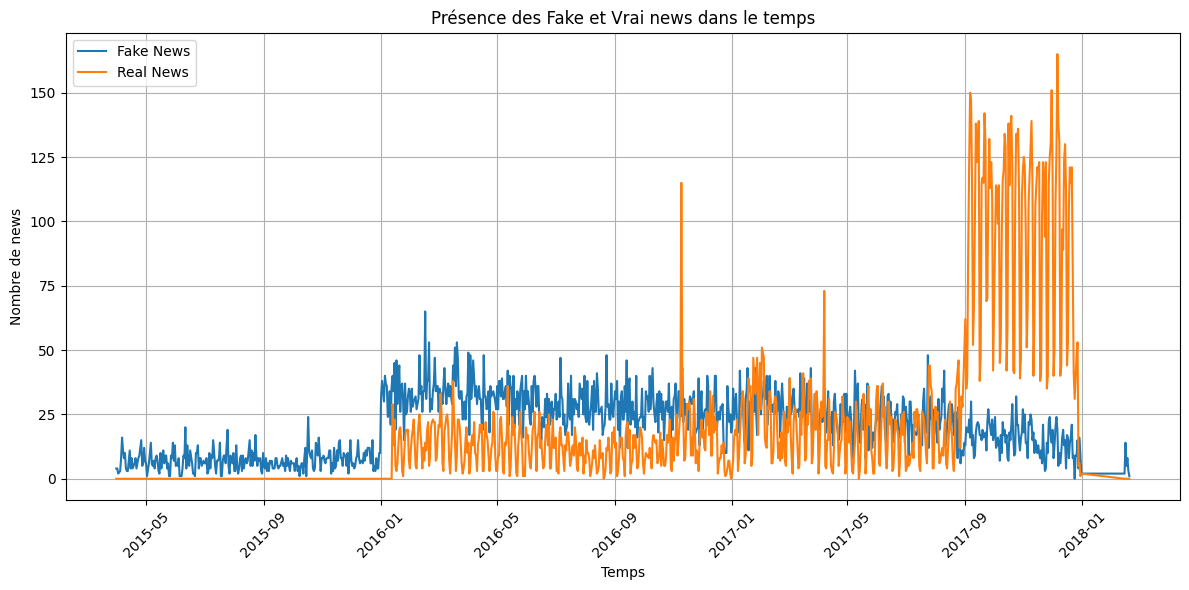

In [168]:
# Tracer les graphiques
plt.figure(figsize=(12, 6))
plt.plot(dates.index, dates['Fake'], label='Fake News')
plt.plot(dates.index, dates['Real'], label='Real News')
plt.title('Présence des Fake et Vrai news dans le temps')
plt.xlabel('Temps')
plt.ylabel('Nombre de news')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotation des dates sur l'axe x pour une meilleure lisibilité
plt.tight_layout()  # Ajuster la mise en page pour éviter que les étiquettes ne se chevauchent
plt.show()


On peut observer que de la date de départ du 2015-03-31 jusqu'a 2016-1-31 les Fake news sont plus présent, et les vrai news sont inéxistants.
À partir de 2016, les vrai news ont augmenté de manière conséquente, mais les fake news rèstent dominant et constant, jusqu'a 2018. Les vrai news, présente plus d'írrégularité de parution entre 2016 et 2018, la periode des vrai news sur les fake news attaint son sommet entre 2017-09-01 à 2018-01-01.

Si on devrais entrainer notre model, il serait potentiellemenet important de ne pas inclure la date, car il se peut que le model prédise la validité d'une news en fonction de sa periode de parution.

In [169]:
df.head()

title  \
0  GERMANY: Father And Sons Stab 20 Yr Old Syrian...   
1   Trump Stole An Idea From North Korean Propaga...   
2   The Trump Family’s Expressions During Ted Cru...   
3  REINCE PRIEBUS Embarrasses Snarky NBC Meet The...   
4  BREAKING: GANG THAT CAN’T SHOOT STRAIGHT: Vote...   

                                                text          subject  \
0  This story is for everyone who believes hundre...  Government News   
1  Jesus f*cking Christ our President* is a moron...             News   
2  Make no mistake about it: Ted Cruz is horrible...             News   
3  The entire premise for Chuck Todd s position i...         politics   
4  Speaker Ryan:  We were on the cusp of achievin...         politics   

        date                                    title_processed  \
0 2015-10-18  germani father son stab yr old syrian daughter...   
1 2017-07-14  trump steal idea north korean propaganda parod...   
2 2016-07-21  trump famili express te cruz rnc speech priceless   
3 2016-12-11  reinc priebu embarrass snarki nbc meet press h...   
4 2017-03-24  break gang can not shoot straight vote cancel ...   

                                      text_processed  isFake  
0  stori everyon believ hundr thousand muslim syr...    True  
1  jesu fcke christ presid moron satisfi simpli w...    True  
2  make mistak ted cruz horribl get admir abil st...    True  
3  entir premis chuck todd posit two medium repor...    True  
4  speaker ryan cusp achiev ambit we ve year come...    True

In [170]:
data=df[['title_processed','text_processed','isFake']]

In [171]:
#check the nan values
data.isnull().sum()

title_processed    0
text_processed     0
isFake             0
dtype: int64

In [172]:
# check that he has empty values
data.isna().sum()

title_processed    0
text_processed     0
isFake             0
dtype: int64

In [173]:
#we get now a dataset only with the text, the title and the values to predict. 
data=df[['title_processed','text_processed','isFake']].sample(frac=1).reset_index(drop=True) #on mélange le dataset puis on le reset les index.
data.to_csv('title_text.csv')

## Modification du texte en données numériques (BERT)

Les données ont été nettoyées, nous pouvons nous concentrer sur la transformation de texte en données numériques.

Comme les informations principales pour distinguer les Fake news des vraies r sur le texte, nous devons nous focaliser sur ces informations. Il est donc crucial de transformer le texte en données numériques afin que notre modèle puisse utiliser ces données pour trouver la bonne réponse. Nous allons utiliser le tokenizer BERT pour cette tâche.

### Le fonctionnement du tokenizer BERT

Le tokenizer BERT transforme le texte en tokens, puis convertit ces tokens en nombres que le modèle peut comprendre. Voici le processus :

1. **Tokenisation** : BERT commence par diviser le texte en mots ou en morceaux de mots appelés tokens. Ils sont plus petits que des mots complets et incluent souvent des parties de mots.

2. **Conversion en identifiants** : Chaque token est ensuite converti en un identifiant unique. Cet identifiant correspond à une entrée dans le vocabulaire de BERT, qui est une grande liste de tous les tokens connus par le modèle.

3. **Vectorisation** : à partir des identifiants, nous créons des vecteurs qui représentent le texte.

### Pourquoi utiliser BERT?

BERT est  puissant pour comprendre le contexte des mots dans une phrase, ce qui le rend très efficace pour des tâches comme la détection de fake news. En utilisant les tokens et les vecteurs générés, notre modèle peut apprendre des nuances du langage et mieux distinguer le vrai du faux.

In [174]:
X = data['text_processed']
#check nan values
print(X.isnull().sum())

0


In [175]:
data.head()

title_processed  \
0  cnn propagandist jake tapper claim speak great...   
1  voodoo doughnut oneofakind dessert perfect moc...   
2  clinton weigh make invest incom taxabl social ...   
3            here trump muslim ban absolut necessari   
4  trump accus qatar fund terror sell billion wor...   

                                      text_processed  isFake  
0  jake tapper give oscarworthi perform fake conc...    True  
1  voodoo doughnut uniqu dessert shop portland or...    True  
2  nashua new hampshir reuter we democrat preside...   False  
3  big thing presid peopl protect enemi refus def...    True  
4  last week donald trump call qatar stop fund te...    True

In [176]:
# Create the tokenizer
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model_bert = BertModel.from_pretrained('bert-base-uncased')

# Set the maximum sequence length
max_seq_length = 512

# Truncate or pad the tokenized sequences
X = X.apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=max_seq_length, truncation=True, padding='max_length'))
print(X)

0        [101, 5180, 11112, 4842, 2507, 7436, 5172, 207...
1        [101, 21768, 23126, 24072, 4895, 18515, 2226, ...
2        [101, 10594, 6692, 2047, 10654, 4523, 11961, 2...
3        [101, 2502, 2518, 3653, 5332, 2094, 21877, 736...
4        [101, 2197, 2733, 6221, 8398, 2655, 12577, 264...
                               ...                        
41590    [101, 3653, 5332, 2094, 3942, 7683, 5958, 5027...
41591    [101, 9664, 2128, 19901, 2095, 11614, 5695, 26...
41592    [101, 18318, 11880, 2072, 28879, 2128, 19901, ...
41593    [101, 2899, 2128, 19901, 2047, 3951, 3021, 163...
41594    [101, 21388, 3501, 2128, 19901, 2149, 3653, 53...
Name: text_processed, Length: 41595, dtype: object


In [177]:
y = data['isFake'].astype(int) #make it numerical
print(y.value_counts())

isFake
0    20820
1    20775
Name: count, dtype: int64


Nous stoquons le dataset tokenizer dans un fichier nommé `x_y_dataset.csv` 

In [178]:
#we create a dataframe from x and y 
x_y_dataset= pd.DataFrame({'X':X,'y':y})
x_y_dataset.to_csv('x_y_dataset.csv')

nous stoquons le tokenizer dans un fichier pickle nommé `bert_tokenizer.pickle`. La raison est que nous allons utiliser le tokenizer sur `valid_clean.csv` dans les fichiers des modèles pour évaluer les performances sur des données qu'il n'a jamais vu.

In [179]:
# we save the tokenizer
import pickle
with open('bert_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)